![CEE Masthead](http://kyrill.ias.sdsmt.edu/wjc/eduresources/CEE_284_Masthead.png)

# "I Got it From Agnes" (Diff-e-Fu Edition)
# Epidemic Modeling

## Trigger warning
When Dr. Capehart does this in a live session, you get to hear the full (and sometimes uncensored) rant about when a certain PhD student brought their child to sit (in his good chair) with a very distinctive cough to find out by an email the day after that he had been exposed to Whopping Cough.

Get your [Tdap](https://www.cdc.gov/vaccines/hcp/vis/vis-statements/tdap.html)!

## Introduction
This a Python program is an example of a "Kermack-McKendrick Model" in epidemic modeling.  


This is also a good example of 
*  Scripting in Python
*  Solving Differential Equations in Python
*  Creating a Policy-Relevant Model
*  Illustrating  how to code coupled systems of equations.
*  Why you should be getting your flu shot.

The basics of a Kermack-McKendrick Model is that you have [typically] three sub-populations in a community where something icky is going around.  This is normally called an "SIR" Model:
*  **Susceptibles** : people who in principle can get sick (in this case we will bundle a block of people who are immunized into this block)
*  **Infected** : people who have the disease and can spread it into the Susceptable population
*  **Recovered** : people who have had the disease and are now immune.
*  To this category we're adding a "**Fatalities**" category because we are monsters.  "We also don't use [Salk](https://www.youtube.com/embed/milG4Aobnes?&start=187&end=190)"

Other versions of this system can distribute the Infected category into subgroups that symptomatic (changing their behavior in contrast to the other classes [not including the dead], contagious [at different levels of symptomatic or asymptomatic]).  

You can break the "Susceptible" group into those with temporary immunity from their mothers, permanent immunity by random chance, and immunity from immunization.  

You can have recovered people who have been infected lose their immunity.  

In short, you can let your Pestilence Horseman run wild because “it’s only a model.”

Remember that this is a *simple* model.  The pro's working in operational epidemiology have far more sophisticated models.


## Sketching the Model Environment and the Kermack-McKendrick Equations

It's always nice to sketch and doodle our models. The black letters will be our variables.  (We're not doing the "cordon sanitaire" option (where healthy people wall themselves off from the sick people) in this example.

![SIR Modeling System Image](http://kyrill.ias.sdsmt.edu/wjc/eduresources/SIR_Image.png)

This creates the following system of equations with the labeled parameters above 

$$
\begin{aligned}
\frac{dS}{dt} &= -\beta SI    \\ \\
\frac{dI}{dt} &= +\beta SI - \gamma I - \omega I   \\ \\
\frac{dR}{dt} &= +\gamma I   \\ \\
\frac{dF}{dt} &= +\omega I  \\ \\
\end{aligned}
$$ 

The above $\beta$ term is a combination of $\kappa$, $p$, and $i$.  We will show how they are constructed as we move through this exercise.



## Libraries

Let's start with the libraries

* [NumPy](https://docs.scipy.org/doc/NumPy/reference/routines.math.html) for some basic math functions
* [SciPy](https://docs.scipy.org/doc/scipy/reference/integrate.html) for ODE solving
* [SymPy](https://www.sympy.org/en/index.html) for symbolic solutions
* [Matplotlib](https://matplotlib.org) for plotting

also...

* [IPython](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html) for document support (this is just to import a youtube video)


In [1]:
################################################
#
# Libraries
#

import numpy             as np
import scipy             as sci
import scipy.integrate   as sciint
import sympy             as sym
import matplotlib.pyplot as plt

# Notice here that this is using a very different 
#   method to pull in functions.
#
#   I normally don't import libraries this way
#
#   This is simply (as the name implies) to bring
#   in a youtube video.

from IPython.display import YouTubeVideo


#
################################################

### Setting up the Code

To do this we will break this process down into several sub-sections

* set up the time extent of our simulation, "Time Control"
* set up the initial state of our players, "Initial or Boundary Conditions"
* set up the rules for the simulation, "Initialize Parameters"



First let’s set up the time control of our simulation.  There are variants of this system where you can do truly horrific things to the players to this system such as lose their immunity after a while, add new babies who can get sick easily or have temporary maternal immunity, recovered populations become sterile, or weaker with a higher natural death rate.  AES/CEE 615 (Environmental Systems Modeling) explores some of these scenarios at different levels depending on how ~disturbed~ creative the students are for that given semester.  

But in this case we are playing a short-game lasting about a month.  We’d like some high temporal resolution.  So let’s start a simulation of 30 days with a time granularity (time step, $\Delta t$) of about 0.125 days (3-hrs).  

In [2]:
################################################
#
# Time Control
#

#
# Total Duration and Time Interval
#

TimePeriod =  30  # days
DeltaT     =  3./24. # hours -> days

#
# Number of timesteps from 0 to TimePeriod
#

nTime      = int(TimePeriod / DeltaT + 1)

#
# Time Array from 0 to 30 
#
#  This is different from some array generators
#    in python since linspace acutally gives you
#    the stopping value you *asked* for!  (No 
#    need to add an extra time step.)
#

Time = np.linspace(start  = 0,          
                   stop   = TimePeriod, # inclusive must be an integer
                   num    = nTime)

#
################################################

### Setting up Initial/Boundary Conditions
The above equations need a starting point.  In this case, it's our cast of characters.
* Starting Susceptables, $S_0$ (in this run this includes people who are immunized, so technically this just all healthy people).
* Initial Infected Cases, $I_0$ (This/These are our "Patient(s) Zero.  Pro-Tip: Don't be these guys.)  Immunization Rant will be down further in this notebook!
* Recovered, $R_0$ (not to be confused with another $R_o$ that we will discussed shortly)
* Fatalites, $F_0$ (because as mentioned above, we are monsters.)

In [3]:
################################################
#
# Initial Conditions
#

S_0 =  998.0  # Uninfected People (includes Vaccinated)
I_0 =    1.0  # Patients Zero: Arg! We *HATE* that guy!
R_0 =    0.0  # Recovered: 0 since we're just starting
F_0 =    0.0  # Fatalities: Again, 0 since we're just starting

#
################################################

### Setting up Basic Disease ~Rules~ Parameters
Every model needs a set of quantified rules.  For diseases this is difficult to explicitly nail down.  As such, we often rely on a set of expected probabilities.  Here are the traits we'll be working with

Now onto the disease:  We will need to have the

* **contact rate**: the likely number of people who an infected person comes into contact per unit time ($\kappa$)
  * Units: probability of infection per risky contact
 
 
* **infection rate**: the probability of infection when a truly vulerable person is exposed per unit time ($\kappa$) 
  * Units: person-to-person contacts (of $S$'s, $I$'s and $R$'s) per sick person per unit time
 
 
* **recovery rate**: the probability of recovery per unit time for a given infected person ($\gamma$)
  * Units: probability of a given sick person recovering per unit time
 
 
* **fatality rate**: the probability per unit time of an infected person dying from the disesase ($\omega$)
  * Units: probability of a given sick person to take the eternal dirt nap it per unit time.
 
 
* $\beta$ from the above equation system is a little more complex than the original case and is a combination of several of these terms. We'll address this later.
  * Units: new infections per contact between sick and susceptable people per unit time
  
  
* **immunization fraction**: If we want to include factors like artificial or natural immunity ($p$) we can include that, too.  Again, we aren't ready for that yet but we'll assume it's zero for now.
  * Units: Fraction of people ~smart enough~ not stupid enough to listen to Andrew Wakefield and Jenny McCarthy.
  * Education Outreach:  my vaccinated child doesn't have autism, he just doesn't like you.


You can get this through some unit analysis.  If you follow the above diagram you can see how the parts come together.  Beta is officially a time dependant field but it is calculated as a function of values form a single time step.  This makes this a "*diagnostic*" variable. $S\left(t\right)$, $I\left(t\right)$, $R\left(t\right)$, and $F\left(t\right)$ since they are represented in the above equations as time-derivatives.

$$\beta\left(t\right)=\frac{i \kappa (1-p)}{S\left(t\right)+I\left(t\right)+R\left(t\right)}$$


In [4]:
################################################
#
# Disease Traits
#

contact_rate   = 6.00 # typical number of contacts (exposure) per case per day
infection_rate = 0.25 # probabilty of infection on exposure per case per day
recovery_rate  = 0.50 # mean chance of recovery per day per case per day
fatality_rate  = 0.10 # mean chance of fatality per case per day

#
# Public Health Traits
#

immunization_fraction = 0.0 # fraction of artificial immunity

#
################################################

### Value-added Parameters

#### Basic Reproductioin Number, $R_o$

If you've seen the medical thriller "Contagion" the CDC Epidemiologist played by Kate Winslet gives a description of something called the "[Basic Reproductive Number](https://en.wikipedia.org/wiki/Basic_reproduction_number)," or "R-nought" ($R_o$), factor while plague-splaining the spread of the disease to city planners. 

[![Spoiler, Gwyneth Paltrow Dies!](http://kyrill.ias.sdsmt.edu/wjc/eduresources/contagion_poster.png)





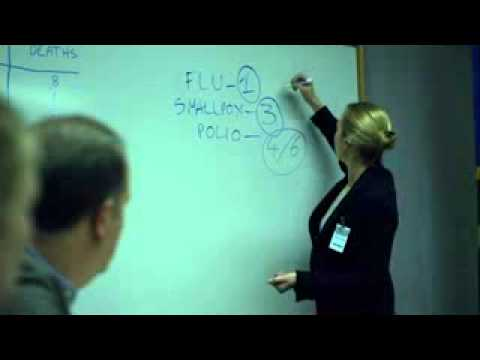

In [5]:
#  embed youtube video
YouTubeVideo('VrATMF_FB9M')


The $R_o$ describes how many people one infected person wil infect.

Typical values for diseases we may encouter in these scenarios include

| Disease | Means of Contagion | ${R_0}$ |
|:---------:|:--------------------:|-------|
|Measles|Airborne|12-18|
|Diphtheria|Saliva|6-7|
|Smallpox|Airborne droplet|5–7|
|Polio|Fecal-oral route|5–7|
|Rubella|Airborne droplet|5–7|
|Pertussis|Airborne droplet from coughing in the prof's office|5-6|
|Mumps|Airborne droplet|4–7|
|(Conjunctivitis) "Pink Eye"|Dirty Lab Goggles|~4|
|HIV/AIDS|Sexual contact|2–5|
|SARS|Airborne droplet|2–5|
|COVID-19 (ests.) |Airborne droplet|1.4–3.8|
|Influenza (1918 pandemic strain)|Airborne droplet|2–3|
|Ebola (2014 Ebola outbreak)|Bodily fluids|1.5-2.5|
|MERS|Airborne droplet|0.3-0.8|


$R_o$'s greater than 1 indicate a disease that will spread through the population.  The higher the $R_o$, the faster the spread.  $R_o$'s below 1 will likely self-contain due to low probability if infection (not every case will result in a new case but an influx of sick people may create a critical mass of "players" for some "Susceptables" to loose to the odds). 
Using our parameters we can derive $R_o$ via unit analysis as

$$R_o =\frac{i \kappa}{\gamma +\omega}$$

In [6]:
################################################
#
# Basic Reproductive Number
#

Ro = infection_rate * contact_rate / (recovery_rate+fatality_rate)

print("Basic Reproductive Number, Ro =", Ro)

#
################################################

Basic Reproductive Number, Ro = 2.5


#### #We'reDoingShots!
In this case we can play with a fraction of the population that enter the game with either natural immunity or have been immunized. This is the $p$ parameter above.

This also allows us to bring up the idea of herd immunity which is one of the major battlegrounds in the vaccine "controversy."

Let's consider 

Assumung that $R=0$ and $S\gg I$,

$$\begin{aligned}
\frac{dI}{dt} &= \frac{ i \kappa \left( 1-p \right) }{S+I+ \left( R=0 \right)} S I - \left( \gamma + \omega \right) I  \\
0 &= \frac{i \kappa\left(1-p\right)}{\left[(S+I) \approx S\right]}S\;I-\left(\gamma +\omega \right)I  \\
0 &= \frac{i \kappa\left( 1-p \right) }{S} S I - \left( \gamma +\omega \right) I \\
0 &= I \left[ \frac{i \kappa \left( 1-p \right) }{S}S-\left( \gamma +\omega \right) \right] \\
0 &= I \left[ i \kappa \left(1-p\right)- \left( \gamma +\omega \right) \right] \\
0 &= i \kappa \left( 1-p \right)- \left( \gamma +\omega \right) \\
i \kappa\left(1-p\right) &= \gamma +\omega \\
1-p &= \frac{\gamma +\omega }{i \kappa} \\
1-p &= \frac{1}{R_o} \\
p &= 1 - \frac{1}{R_o}
\end{aligned} $$

This "critical" value of public immunity fraction, $p$, or $p_c$, is the "herd immunity."  Thus for a $R_o$ of 12 (the low end of the communicability of Measles), to force the functional $R_o$ for Measles down to zero or less, over 90% of the populus must have artificial immunity.  

In [7]:
################################################
#
# Herd Immunity
#

herd_immunity = 1 - 1/Ro

print("Herd Immunity Threshold, pc =", 
      herd_immunity)

#
################################################

Herd Immunity Threshold, pc = 0.6


## Drafting our Prognostic and Diagnostic Equations

In this scenario we are going to show off SciPy's integrating features.  Most of them will fit into the following setup.  

We will need a single function that contains all of our prognostic equations, $\frac{dS}{dt}$, $\frac{dI}{dt}$, $\frac{dR}{dt}$, and $\frac{dF}{dt}$.  Since two of our equations need a value for $\beta$, that gets put in there too.

### The Function for our ODE Solver

Here we will create a single function that bundles all of our equations.  For the finite differencing version we are going to use separate equations.

In [8]:
################################################
#
# Our Single Beta, S, I, R, F function
#
#   We pass a vector of [S, I, R, F] through our system.   
#

def dSIRF(t,  # the parameter that it will integrate over 
          X): # the fields containing inputs in order
              # of the output equations
    ################################################
    #   
    #
    # Expand our Input vector, Y into names we humans would prefer
    #
    
    S = X[0] # Susceptables
    I = X[1] # Invected
    R = X[2] # Recovered
    F = X[3] # Fatalities
    
    #
    # Beta operates as an internal variable in this case.
    #
    
    beta = (1-immunization_fraction)*(infection_rate*contact_rate)/(S+I+R)

    #
    # Adding an empty array to contain the equations
    #
    
    dXdt = np.empty(4)
    
    #
    # Load the array with our prognostic formulae
    #
    
    dSdt = -beta * I * S
    dIdt =  beta * I * S - (recovery_rate + fatality_rate) * I
    dRdt =  recovery_rate * I
    dFdt =  fatality_rate * I
    
    #
    # Return the prognostic array
    #
    
    return( [dSdt,
             dIdt,
             dRdt,
             dFdt] )
    #
    ################################################

### Solve that system!

Here we are using the [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) which is designed for initial value problems.

The default solver for this function is a fourth-order Runge-Kutta.  (We've included the specific line that would call this below, anyway.)

Here is what you need for this at minimum

1. an callable function that includes the basic functions.  The arguments can be as follows:
  1.  the first value needs to be the single scalar for the derivative in the function(s).  For us, that's time.
  2.  a 1-D vector or scalar of there's just one derivative containing the initial conditions for the function(s)
2. a two-element list of your start and end points for the duration of your solution range (for this case it will be for your valid time range).
3. list of your initial conditions.

There are fancier things you can do where you can use paramters as an argument, such as changes in herd immunity, but right now we are going for simplicity in the scarier function calls. 


In [9]:
################################################
#
# Use the solve_ivp function
#

Y = sciint.solve_ivp(dSIRF,                 # Function(t, F(t)) 
                     [0, TimePeriod],       # start and end times
                     [S_0, I_0, R_0, F_0],  # initial conditons, Fo
                     method       = "RK45", # method (defaults to RK45)
                     dense_output = True)   # create a continuous solution

#
################################################

The output for the above function is an object with a number of return variables that can be accessed from your return value (for the above, that's the Y).  

We want the contents of the "sol" object which contains what we need to access the results of the solution.

"sol" requires an argument (just like a function).  So if we want a time series, we throw in our array.  If we want any single time value, we can enter that time as well.

If the input is a vector of time values in our case, it will be a 2-d vector so that the first element is the time dimension, and the second dimension are your the solution to your input equations.  For us that's $S(t)$, $I(t)$, $R(t)$, & $F(t)$.

To get that final array of output the call for us us Y.sol(times).T

Let's take a peak at it.

In [10]:
################################################
#
# Peaking at Y()
#

print("Look at all contents of Y")
print()
display(Y)

#
# Peaking at Y.sol()
#
# Let's just see what happens over 5 days with a delta-t of one day
#

short_time_array = np.arange(0, 5+1, 1)

print("short-time-array-for-this-demo : ",short_time_array)



print()
print("content of Y.sol(short_time_array) found in T")
print(Y.sol(short_time_array).T)

#
################################################

Look at all contents of Y



  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 110
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x1276bb990>
   status: 0
  success: True
        t: array([0.00000000e+00, 2.77211028e-03, 3.04932130e-02, 3.07704241e-01,
       1.21488132e+00, 2.49912951e+00, 4.00059422e+00, 5.69328566e+00,
       8.01488342e+00, 1.06695968e+01, 1.35702417e+01, 1.62182213e+01,
       1.86023748e+01, 2.08733422e+01, 2.31192520e+01, 2.53560879e+01,
       2.75900459e+01, 2.98238692e+01, 3.00000000e+01])
 t_events: None
        y: array([[9.98000000e+02, 9.97995841e+02, 9.97953675e+02, 9.97469014e+02,
        9.94707536e+02, 9.84104824e+02, 9.42640642e+02, 7.90464311e+02,
        3.91344772e+02, 1.62720773e+02, 1.03655594e+02, 9.08250139e+01,
        8.72992419e+01, 8.61384463e+01, 8.57237197e+01, 8.55727441e+01,
        8.55174022e+01, 8.54970661e+01, 8.54961682e+01],
       [1.00000000e+00, 1.00249383e+00, 1.02777587

short-time-array-for-this-demo :  [0 1 2 3 4 5]

content of Y.sol(short_time_array) found in T
[[9.98000000e+02 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.95575997e+02 2.45233046e+00 8.09726715e-01 1.61945343e-01]
 [9.89672314e+02 5.98025017e+00 2.78953002e+00 5.57906003e-01]
 [9.75506573e+02 1.43889600e+01 7.58705568e+00 1.51741114e+00]
 [9.42669002e+02 3.35841169e+01 1.89557340e+01 3.79114680e+00]
 [8.72496243e+02 7.30471211e+01 4.45471963e+01 8.90943927e+00]]


## Exploring the Results
Let's Plot it!  Here we are going to pull each value in sol.T so we can specifically customize each color.

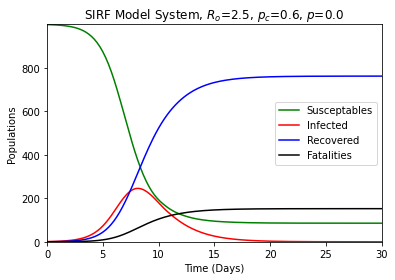

In [11]:
################################################
#
# Plot Results
#

plt.plot(Time, Y.sol(Time).T[:,0], "g", # susceptables
         Time, Y.sol(Time).T[:,1], "r", # infected
         Time, Y.sol(Time).T[:,2], "b", # recovered
         Time, Y.sol(Time).T[:,3], "k") # fatalities
plt.title("SIRF Model System, $R_o$="+
          str(Ro) +
          ", $p_c$=" + 
          str(herd_immunity) +
          ", $p$=" + 
          str(immunization_fraction))
plt.xlim(0, TimePeriod)
plt.ylim(0, (S_0 + I_0 + R_0 + F_0))
plt.xlabel('Time (Days)')
plt.ylabel("Populations")
plt.legend(["Susceptables", 
            "Infected",
            "Recovered", 
            "Fatalities"])
plt.show()


#
################################################

### Exploring Herd Immunity

Let's now explore three values of Herd Immunity.  We will run three cases with 25%, 50% and 75% of the populus being vaccinated.

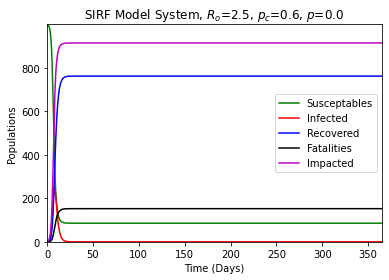

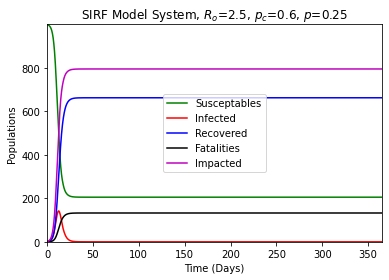

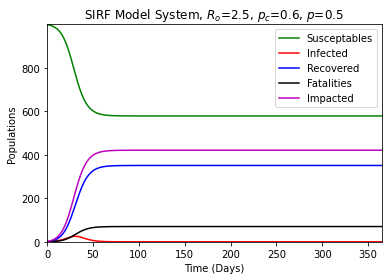

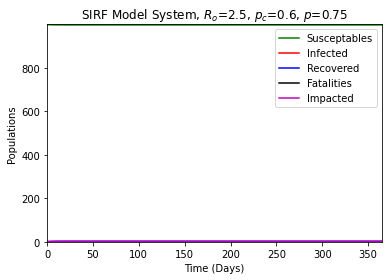

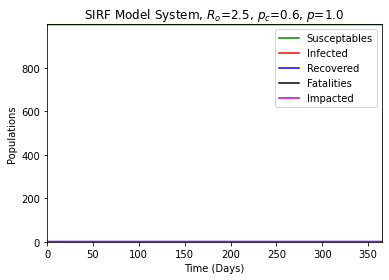

In [12]:
################################################
#
# Plot Results
#

# We're also going to go for a longer game (one year)

TimePeriod = 365.
nTime      = int(TimePeriod / DeltaT + 1)
Time       = np.linspace(start  = 0,          
                         stop   = TimePeriod, # this is *inclusive*
                         num    = nTime)





for immunization_fraction in [0.00,0.25, 0.50, 0.75, 1.00]:
    ############################################
    #
    # Run the Solver
    #
    Y = sciint.solve_ivp(dSIRF, 
                         [0, TimePeriod], 
                         [S_0, I_0, R_0, F_0],
                         method = "RK45",
                         dense_output=True)
    
     #
    # Tally the total number of impacted cases
    #
    
    Total_Impacted_Cases = Y.sol(Time).T[:,1] + \
                           Y.sol(Time).T[:,2] + \
                           Y.sol(Time).T[:,3]
    
    #
    # Plot Each Graph
    #
    plt.plot(Time, Y.sol(Time).T[:,0],   "g", # susceptables
             Time, Y.sol(Time).T[:,1],   "r", # infected
             Time, Y.sol(Time).T[:,2],   "b", # recovered
             Time, Y.sol(Time).T[:,3],   "k", # fatalities
             Time, Total_Impacted_Cases, "m") # impacted cases
    plt.xlim(0, TimePeriod)
    plt.ylim(0,(S_0 + I_0 + R_0 + F_0))
    plt.title("SIRF Model System, $R_o$="+
          str(Ro) +
          ", $p_c$=" + 
          str(herd_immunity) +
          ", $p$=" + 
          str(immunization_fraction))
    plt.xlabel('Time (Days)')
    plt.ylabel("Populations")
    plt.legend(["Susceptables", 
                "Infected",
                "Recovered", 
                "Fatalities",
                "Impacted"])
    plt.show()
    #
    ############################################



#
################################################

Since this is more about learning programming tricks in Python rather than learning  we can do this again... not with a loop but with a 4-panel.  

I'm going to "steal" the 4-panel section from our [plotting tutorial](http://kyrill.ias.sdsmt.edu/wjc/eduresources/CEE284_Python/Course_Materials/Classroom%20Sessions/Session%202%20-%20Arrays%20Math%20and%20Plotting%20in%20Python/Part%202%20--%20Arrays,%20Math,%20and%20Plotting%20in%20Python.html) for a lot of this material because I forget this operation *way* too often.

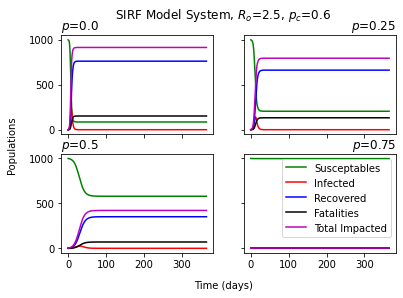

In [13]:
#############################################
#
#  Make a 2x2 plot with differennt logs on the 
#    axes to demonstrate leveraging the ax-and-fig
#    method of plotting.
#

#
# We'll start with the subplot command which
#    will let us make 2 rows (first argument)
#    and 2 columns.  
#
# The second modifier pair instruct the matplotlib
#    "share" the axis attributes for each plot.
#
# When we do this, FIG will represent the atributes 
#     of the whole plotting area.
#
# The acutal "subplots" are typically called "ax"
#     which you can consider to be the 
#

fig, ax = plt.subplots(2,            # 2 rows in the y
                       2,            # 2 cols in the x
                       sharex='col', # set the colum (x axes to match)
                       sharey='row') # set the rows (y axes to match)



# Let's have our Top Left (0,0) plot represent the p=0 case

immunization_fraction = 0.00


Y = sciint.solve_ivp(dSIRF,
                     [0, TimePeriod],
                     [S_0, I_0, R_0, F_0],
                     method = "RK45",
                     dense_output=True)

Total_Impacted_Cases = Y.sol(Time).T[:,1] + \
                       Y.sol(Time).T[:,2] + \
                       Y.sol(Time).T[:,3]
    
ax[0, 0].plot(Time, Y.sol(Time).T[:,0],   "g", # susceptables
              Time, Y.sol(Time).T[:,1],   "r", # infected
              Time, Y.sol(Time).T[:,2],   "b", # recovered
              Time, Y.sol(Time).T[:,3],   "k", # fatalities
              Time, Total_Impacted_Cases, "m") # impacted cases

ax[0, 0].set_title("$p$="+str(immunization_fraction),
                   loc='left')

# Let's have our Top Right (0, 1) plot represent the p=0.25 case
#  we are only going to put the legend on one pannel 
#  (this Lower Right one)

immunization_fraction = 0.25


Y = sciint.solve_ivp(dSIRF,
                     [0, TimePeriod],
                     [S_0, I_0, R_0, F_0],
                     method = "RK45",
                     dense_output=True)


Total_Impacted_Cases = Y.sol(Time).T[:,1] + \
                       Y.sol(Time).T[:,2] + \
                       Y.sol(Time).T[:,3]

ax[0, 1].plot(Time, Y.sol(Time).T[:,0],   "g", # susceptables
              Time, Y.sol(Time).T[:,1],   "r", # infected
              Time, Y.sol(Time).T[:,2],   "b", # recovered
              Time, Y.sol(Time).T[:,3],   "k", # fatalities
              Time, Total_Impacted_Cases, "m") # impacted cases

ax[0, 1].set_title("$p$="+str(immunization_fraction),
                   loc='right')

# Let's have our Lower Left (1, 0) plot represent the p=0.25 case

immunization_fraction = 0.50


Y = sciint.solve_ivp(dSIRF,
                     [0, TimePeriod],
                     [S_0, I_0, R_0, F_0],
                     method = "RK45",
                     dense_output=True)

Total_Impacted_Cases = Y.sol(Time).T[:,1] + \
                       Y.sol(Time).T[:,2] + \
                       Y.sol(Time).T[:,3]

ax[1, 0].plot(Time, Y.sol(Time).T[:,0],   "g", # susceptables
              Time, Y.sol(Time).T[:,1],   "r", # infected
              Time, Y.sol(Time).T[:,2],   "b", # recovered
              Time, Y.sol(Time).T[:,3],   "k", # fatalities
              Time, Total_Impacted_Cases, "m") # impacted cases

ax[1, 0].set_title("$p$="+str(immunization_fraction),
                   loc='left')

# Let's have our Lower Right (1, 1) plot represent the p=0.75 case
#   which for us is on the safer side of our needed herd immunity
#   the legend goes here because it's rather big.

immunization_fraction = 0.75


Y = sciint.solve_ivp(dSIRF,
                     [0, TimePeriod],
                     [S_0, I_0, R_0, F_0],
                     method = "RK45",
                     dense_output=True)

Total_Impacted_Cases = Y.sol(Time).T[:,1] + \
                       Y.sol(Time).T[:,2] + \
                       Y.sol(Time).T[:,3]
    
ax[1, 1].plot(Time, Y.sol(Time).T[:,0],   "g", # susceptables
              Time, Y.sol(Time).T[:,1],   "r", # infected
              Time, Y.sol(Time).T[:,2],   "b", # recovered
              Time, Y.sol(Time).T[:,3],   "k", # fatalities
              Time, Total_Impacted_Cases, "m") # impacted cases

ax[1, 1].set_title("$p$="+str(immunization_fraction),
                   loc='right')

ax[1, 1].legend(["Susceptables", 
                 "Infected",
                 "Recovered", 
                 "Fatalities",
                 "Total Impacted"])

# add the big title

fig.suptitle("SIRF Model System, $R_o$="+
             str(Ro)    +
             ", $p_c$=" + 
             str(herd_immunity))


# you have to kludge a common axis here which is
#   rather disapointing (maybe the next version of 
#   matplotlib will have it.)
#
# we use the fig.text function
#  the first two arguments are the x and y centers of
#  the plot in the larger plotter space
#

fig.text(0.50, 0.00, 
         'Time (days)', 
         ha       = 'center')

fig.text(0.00, 0.50, 
         'Populations', 
         va       = 'center', 
         rotation = 'vertical')

plt.show()

#
############################################

## Exploring Herd Immunity

Let's look more closely at how the herd immunity chagnes the overall impact of the diseases (counting results)

This also shows how to loop through the system and load the results into an array

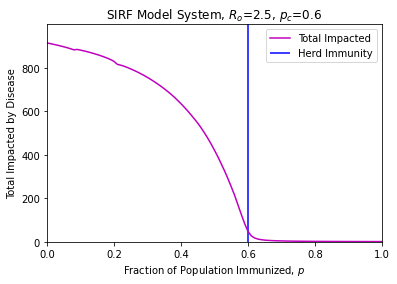

In [14]:
################################################ 
#
# Plot Results
#

#
# let's first make an array to carry our 
#    immune factor
#

# Make the immunity (dp = 0.01 so we have 101 slots)

immune_array = np.linspace(0, 1,101)

# clone the immune array as zeros for the impact array

impact_array = np.zeros(immune_array.size)


for i in range(0, immune_array.size):
    ####################################
    #
    # Load Immunization Fraction
    #
    immunization_fraction = immune_array[i]
    #
    # Run the ODE Solver
    #
    Y = sciint.solve_ivp(dSIRF,
                        [0, TimePeriod], 
                        [S_0, I_0, R_0, F_0],
                        method = "RK45",
                        dense_output=True)
    #
    # for the very last time step (all we need)
    #    just extract the values at the end of our
    #    simulation "TimePeriod"
    #    #
    # get the last three values, skipping the 
    #   Y.sol(Time).T[1:]
    #
    # and add them up with np.sum()
    #
    impact_array[i] = np.sum(Y.sol(TimePeriod).T[1:])
    #
    ####################################


plt.plot(immune_array,
         impact_array,
        "m")
plt.vlines(herd_immunity, 
           0, (S_0 + I_0 + R_0 + F_0), 
           'b')
plt.legend(["Total Impacted",
            "Herd Immunity"])
plt.xlim(0, 1)
plt.ylim(0, (S_0 + I_0 + R_0 + F_0))
plt.title("SIRF Model System, $R_o$="+
          str(Ro) +
          ", $p_c$=" + 
          str(herd_immunity))
plt.xlabel("Fraction of Population Immunized, $p$")
plt.ylabel("Total Impacted by Disease")
plt.show()
    
#
################################################

So if you don't have a legitimate medical reason not to take a given immunization (e.g., alergies to the flu vaccines, immunocompromised, etc.), **[GET YOUR FRIGGIN' SHOTS!!!!!](https://www.cdc.gov/vaccines/index.html)**  

(and if your curious about the title of the exercise... click below.)


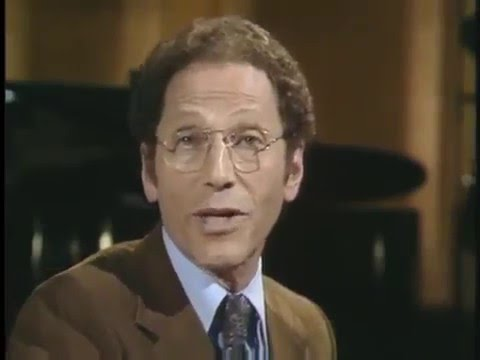

In [15]:
#Tom Lehrer Sing's "I got it from Agness"
YouTubeVideo('R6qFG0uop9k')

## Version Information

In [16]:
################################################################
#
# Loading Version Information
#

%load_ext version_information

%version_information version_information, numpy, scipy, matplotlib

#
################################################################

Software versions
Python 3.7.7 64bit [Clang 11.0.0 (clang-1100.0.33.17)]
IPython 7.13.0
OS Darwin 19.4.0 x86_64 i386 64bit
version_information 1.0.3
numpy 1.18.2
scipy 1.4.1
matplotlib 3.2.1
Sat Apr 25 18:43:17 2020 MDT